## **Setup**

In [1]:
# Import the necesary packages
import os
import gc
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
config = {
    # Basic information
    "AUTHOR": "Kiernan",
    
    # Data information
    "IMAGE_SIZE": 28,
    
    # Training params
    "LR_STYLE": "SCHEDULE", #['REDUCE', 'SCHEDULE']
    "LR": 0.001, #0.000001,
    "BATCH_SIZE": 50,
    "EPOCHS": 30,
    
    # Loss parameters
    "LOSS": "SEMI_HARD", #['HARD', 'SEMI_HARD']
    "MARGIN": 0.5,
    "SOFT": False,
    "DIST_METRIC": "L2", #['L2','squared-L2','angular']
    
    # Model params
    # "RUN_FOR_BASE": "3cmjv1lo",
    # "FREEZE": "ALL", #['ALL', 'BN', 'None'] which layers to freeze in the body model
    
    # Model params
    "FIRST_FILTERS": 16,
    "CONV_LAYERS": 4,
    "N_FILTERS": 8,
    "KERNEL_SIZE": (3,3),
    "EMBEDDING_SIZE": 16,
    "VECTOR_SIZE": 16,
    "DROPOUT": 0.2
}

## **Initialize WANDB**

In [3]:
import wandb
from wandb.keras import WandbCallback
from secrets import WANDB
wandb.login(key=WANDB)
run = wandb.init(project="deep-clustering-evaluation", entity="kmcguigan", group="triplet-model", config=config, job_type="train")

wandb: Currently logged in as: all-off-nothing (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kiern/.netrc
C:\Users\kiern\anaconda3\envs\deep-clustering-analysis\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## **Loading Data**

### **Load the presplit data**

In [4]:
with open('data/train.npy', mode='rb') as infile:
    X_train = np.load(infile, allow_pickle=True)
    y_train = np.load(infile, allow_pickle=True)

with open('data/val.npy', mode='rb') as infile:
    X_val = np.load(infile, allow_pickle=True)
    y_val = np.load(infile, allow_pickle=True)

with open('data/test.npy', mode='rb') as infile:
    X_test = np.load(infile, allow_pickle=True)
    y_test = np.load(infile, allow_pickle=True)

print(f"Train data shape: {X_train.shape} Val data shape: {X_val.shape} Test data shape: {X_test.shape}")

Train data shape: (50000, 28, 28, 1) Val data shape: (10000, 28, 28, 1) Test data shape: (10000, 28, 28, 1)


### **Create a data generator**

In [5]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, X, y, classes):
        self.X = X
        self.y = y
        
        # image meta
        self.dims = (config["IMAGE_SIZE"], config["IMAGE_SIZE"])
        self.channels = 1
        
        # save the meta on what we will be choosing
        self.batch_size = config["BATCH_SIZE"]
        self.samples_per_class = self.batch_size // len(classes)
        assert(self.batch_size % self.samples_per_class == 0)
        
        # create the image loader
        self.indexer = {}
        # min_samples = None
        for cls in classes:
            self.indexer[cls] = np.where(y==cls)[0]
            
        # save the size of a single epoch of data
        self.batches_per_epoch = (self.X.shape[0] // self.batch_size) + 1
        
        super(CustomDataset, self).__init__()
    
    def __len__(self):
        return self.batches_per_epoch

    def on_epoch_end(self):
        gc.collect()
        return

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, *self.dims, self.channels))
        y = np.empty((self.batch_size), dtype=int)
        batch_idx = 0
        for cls in self.indexer.keys():
            samples = np.random.choice(self.indexer[cls], size=self.samples_per_class, replace=False)
            X[batch_idx:batch_idx+self.samples_per_class, :, :, :] = self.X[samples, :, :, :]
            y[batch_idx:batch_idx+self.samples_per_class] = self.y[samples]
            batch_idx = batch_idx+self.samples_per_class
        return X,y

In [6]:
train_ds = CustomDataset(X_train, y_train, [i for i in range(10)])
val_ds = CustomDataset(X_val, y_val, [i for i in range(10)])
test_ds = CustomDataset(X_test, y_test, [i for i in range(10)])

## **Define Metrics**

In [7]:
def pairwise_distance(embeddings, squared=False):
    dot = tf.matmul(embeddings, tf.transpose(embeddings))
    square_norm = tf.linalg.diag_part(dot)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot + tf.expand_dims(square_norm, 0)
    distances = tf.maximum(distances, 0.0)
    if(not squared):
        mask = tf.cast(tf.equal(distances, 0.0), tf.float32)
        distances = distances + mask * 1e-16
        distances = tf.sqrt(distances)
        distances = distances * (1.0 - mask)
    return distances

def angular_distances(embeddings):
    embeddings = tf.math.l2_normalize(embeddings, axis=-1)
    angular_distances = 1 - tf.matmul(embeddings, tf.transpose(embeddings))
    angular_distances = tf.maximum(angular_distances, 0.0)
    mask_offdiag = tf.ones_like(angular_distances) - tf.linalg.diag(tf.ones([tf.shape(angular_distances)[0]]))
    angular_distances = tf.math.multiply(angular_distances, mask_offdiag)
    return angular_distances

def apply_metric(embeddings, labels, metric):
    adj = tf.equal(labels, tf.transpose(labels))
    adj_not = tf.math.logical_not(adj)
    adj = tf.cast(adj, tf.float32) - tf.linalg.diag(tf.ones([tf.shape(labels)[0]]))
    adj_not = tf.cast(adj_not, tf.float32)
    distances = metric(embeddings)
    pos_dist = tf.math.multiply(distances, adj)
    neg_dist = tf.math.multiply(distances, adj_not)
    pos_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(pos_dist, mask=tf.math.equal(adj, 1.0)))
    neg_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(neg_dist, mask=tf.math.equal(adj_not, 1.0)))
    return pos_dist_mean, neg_dist_mean

In [8]:
def positive_distance(labels, embeddings):
    adj = tf.equal(labels, tf.transpose(labels))
    adj = tf.cast(adj, tf.float32) - tf.linalg.diag(tf.ones([tf.shape(labels)[0]]))
    distances = pairwise_distance(embeddings)
    pos_dist = tf.math.multiply(distances, adj)
    pos_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(pos_dist, mask=tf.math.equal(adj, 1.0)))
    return pos_dist_mean

def negative_distance(labels, embeddings):
    adj = tf.math.logical_not(tf.equal(labels, tf.transpose(labels)))
    adj = tf.cast(adj, tf.float32)
    distances = pairwise_distance(embeddings)
    neg_dist = tf.math.multiply(distances, adj)
    neg_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(neg_dist, mask=tf.math.equal(adj, 1.0)))
    return neg_dist_mean

def positive_angular(labels, embeddings):
    adj = tf.equal(labels, tf.transpose(labels))
    adj = tf.cast(adj, tf.float32) - tf.linalg.diag(tf.ones([tf.shape(labels)[0]]))
    distances = angular_distances(embeddings)
    pos_dist = tf.math.multiply(distances, adj)
    pos_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(pos_dist, mask=tf.math.equal(adj, 1.0)))
    return pos_dist_mean

def negative_angular(labels, embeddings):
    adj = tf.math.logical_not(tf.equal(labels, tf.transpose(labels)))
    adj = tf.cast(adj, tf.float32)
    distances = angular_distances(embeddings)
    neg_dist = tf.math.multiply(distances, adj)
    neg_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(neg_dist, mask=tf.math.equal(adj, 1.0)))
    return neg_dist_mean

In [9]:
class MetricHandler:
    def __init__(self, metric):
        self.has_read = {0: False, 1: False}
        self.metric = metric
        self.results = {0: None, 1: None}
        
    def read_metric(self, reader, embeddings, labels):
        if(self.has_read[reader]):
            raise Excpetion(f'{reader} reader re-reading data it already has')
        other = 1 - reader
        if(self.has_read[other]):
            value = self.results[reader]
            self.results[0] = None
            self.results[1] = None
            return value
        metric_results = apply_metric(embeddings, labels, self.metric)
        self.results[0] = metric_results[0]
        self.results[1] = metric_results[1]
        return self.results[reader]
    
distance_handler = MetricHandler(pairwise_distance)
angular_handler = MetricHandler(angular_distances)
    
def pos_distance(labels, embeddings):
    return distance_handler.read_metric(0, embeddings, labels)
def neg_distance(labels, embeddings):
    return distance_handler.read_metric(1, embeddings, labels)

def pos_angle(labels, embeddings):
    return angular_handler.read_metric(0, embeddings, labels)
def neg_angle(labels, embeddings):
    return angular_handler.read_metric(1, embeddings, labels)

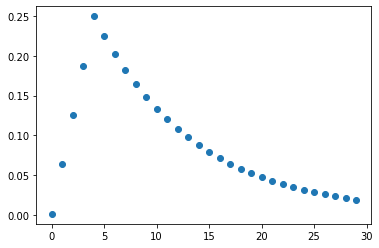

In [10]:
def get_lr_callback(plot=False, batch_size=config['BATCH_SIZE'], epochs=config['EPOCHS']):
    lr_start   = config['LR']
    lr_max     = config['LR'] * 5 * batch_size  
    lr_min     = config['LR']
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    if(plot):
        epochs = list(range(epochs))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        ax = plt.gca()
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

if(config["LR_STYLE"] == "SCHEDULE"):
    lr_callback = get_lr_callback(plot=True)
elif(config["LR_STYLE"] == "REDUCE"):
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2)
else:
    raise Exception(f"config LR_STYLE {config['LR_STYLE']} is not understood")

## **Create Model**

### **Load the pretrained body model**

In [11]:
def freeze_all(model):
    for layer in model.layers:
        layer.trainable=False

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
            
def freeze_none(model):
    for layer in model.layers:
        layer.trainable = True

In [12]:
# body_file = wandb.restore('body.h5', run_path=f"kmcguigan/deep-clustering-evaluation/{config['RUN_FOR_BASE']}")
# body = tf.keras.models.load_model(body_file.name)
# body_output_shape = body.layers[-1].output_shape[-1]
# config['EMBEDDING_SIZE'] = body_output_shape
# if(config["FREEZE"] == "ALL"):
#     freeze_all(body)
# elif(config["FREEZE"] == "BN"):
#     freeze_BN(body)
# elif(config["FREEZE"] == "None"):
#     freeze_none(body)
# else:
#     raise Excpetion(f"config FREEZE is set to {config['FREEZE']} but this freeze method is not understood")
# body.summary()

Model: "body"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 8)        32        
 hNormalization)                                              

In [13]:
def create_body(image_shape):
    inputs = tf.keras.layers.Input(shape=image_shape)
    
    def conv_block(layer_inputs, n_filters, kernel_size, **kwargs):
        x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding="same", **kwargs)(layer_inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        return x
    
    x = conv_block(inputs, config["FIRST_FILTERS"], config["KERNEL_SIZE"], strides=2)
    for _ in range(config["CONV_LAYERS"]):
        x = conv_block(x, config["N_FILTERS"], config["KERNEL_SIZE"])
    
    x = tf.keras.layers.Conv2D(config["EMBEDDING_SIZE"], (1,1), padding="same")(x)
    outputs = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="body")

body = create_body(X_train.shape[1:])
body.summary()

### **Create the head**

In [14]:
def create_head(input_shape):
    inputs = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.Dropout(config["DROPOUT"])(inputs)
    x = tf.keras.layers.Dense(config['VECTOR_SIZE'])(x)
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="head")

head = create_head(input_shape=config['EMBEDDING_SIZE'])
head.summary()

Model: "head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 lambda (Lambda)             (None, 16)                0         
                                                                 
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


### **Create the full model**

In [15]:
model = tf.keras.models.Sequential([
    body,
    head
],
    name="combinedModel"
)
if(config["LOSS"] == "HARD"):
    loss = tfa.losses.TripletHardLoss(margin=config["MARGIN"], distance_metric=config["DIST_METRIC"], soft=config["SOFT"])
elif(config["LOSS"] == "SEMI_HARD"):
    loss = tfa.losses.TripletSemiHardLoss(margin=config["MARGIN"], distance_metric=config["DIST_METRIC"], soft=config["SOFT"])
else:
    raise Exception(f"config LOSS of {config['LOSS']} is not understood")

optimizer = tf.keras.optimizers.Adam(learning_rate=config['LR'])

metrics = [
    positive_distance,
    negative_distance,
    positive_angular,
    negative_angular
]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "combinedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 body (Functional)           (None, 16)                3408      
                                                                 
 head (Functional)           (None, 16)                272       
                                                                 
Total params: 3,680
Trainable params: 272
Non-trainable params: 3,408
_________________________________________________________________


## **Evaluate Models Initial Performance**

In [16]:
def kmeans_cluster_accuracy(X, y):
    embeddings = model.predict(X)
    kmeans = KMeans(n_clusters=10, random_state=123)
    labels = kmeans.fit_predict(embeddings)
    
    label_mappings = {}
    for label in np.unique(labels):
        values, counts = np.unique(y[np.where(labels==label)], return_counts=True)
        label_mappings[label] = values[np.argmax(counts)]
    print(label_mappings)
    
    map_labels = np.vectorize(lambda x: label_mappings[x])
    mapped_labels = map_labels(labels)
    return accuracy_score(y.reshape((-1,1)), mapped_labels.reshape((-1,1)))

In [17]:
acc = kmeans_cluster_accuracy(X_test, y_test)
print(acc)
run.log({'test/init-test-clustering-accuracy': acc})

{0: 1, 1: 0, 2: 9, 3: 3, 4: 2, 5: 8, 6: 6, 7: 4, 8: 5, 9: 7}
0.9706


In [18]:
acc = kmeans_cluster_accuracy(X_val, y_val)
print(acc)
run.log({'test/init-val-clustering-accuracy': acc})

{0: 8, 1: 6, 2: 2, 3: 1, 4: 0, 5: 4, 6: 3, 7: 9, 8: 5, 9: 7}
0.9686


## **Train the Model**

In [19]:
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
hist = model.fit(train_ds,
                 validation_data=val_ds,
                 epochs=config["EPOCHS"],
                 callbacks=[stopper, lr_callback, WandbCallback()])

Epoch 1/30
1001/1001 [==============================] - 14s 10ms/step - loss: 0.2256 - positive_distance: 0.6071 - negative_distance: 1.4419 - positive_angular: 0.2091 - negative_angular: 1.0765 - val_loss: 0.1170 - val_positive_distance: 0.4326 - val_negative_distance: 1.4508 - val_positive_angular: 0.1208 - val_negative_angular: 1.0902 - lr: 0.0010
Epoch 2/30
1001/1001 [==============================] - 8s 8ms/step - loss: 0.1969 - positive_distance: 0.5368 - negative_distance: 1.4459 - positive_angular: 0.1711 - negative_angular: 1.0859 - val_loss: 0.1264 - val_positive_distance: 0.4348 - val_negative_distance: 1.4470 - val_positive_angular: 0.1227 - val_negative_angular: 1.0866 - lr: 0.0632
Epoch 3/30
1001/1001 [==============================] - 9s 9ms/step - loss: 0.1980 - positive_distance: 0.5376 - negative_distance: 1.4459 - positive_angular: 0.1713 - negative_angular: 1.0858 - val_loss: 0.1157 - val_positive_distance: 0.4297 - val_negative_distance: 1.4515 - val_positive_angul

In [20]:
ev = model.evaluate(test_ds, return_dict=True)
log_dict = {f'test/{met}': val for met, val in ev.items()}
run.log(log_dict)

201/201 [==============================] - 1s 6ms/step - loss: 0.1175 - positive_distance: 0.4309 - negative_distance: 1.4513 - positive_angular: 0.1202 - negative_angular: 1.0913


In [21]:
acc = kmeans_cluster_accuracy(X_test, y_test)
print(acc)
run.log({'test/test-clustering-accuracy': acc})

{0: 3, 1: 8, 2: 4, 3: 2, 4: 5, 5: 0, 6: 9, 7: 1, 8: 7, 9: 6}
0.9773


In [22]:
acc = kmeans_cluster_accuracy(X_val, y_val)
print(acc)
run.log({'test/val-clustering-accuracy': acc})

{0: 6, 1: 9, 2: 3, 3: 1, 4: 2, 5: 0, 6: 8, 7: 7, 8: 4, 9: 5}
0.9748


In [23]:
run.finish()

epoch,▁▂▃▅▆▇█
loss,█▁▂▁▁▁▁
lr,▁▃▄▆█▇▇
negative_angular,▁██████
negative_distance,▁█▇████
positive_angular,█▁▁▁▁▁▁
positive_distance,█▁▁▁▁▁▁
test/init-test-clustering-accuracy,▁
test/init-val-clustering-accuracy,▁
test/loss,▁
test/negative_angular,▁
